---
## Classification - MNIST dataset
---

Exploring the popular MNIST dataset. 

Tensorflow provides a function to ingest the data.

In [1]:
# Necessary imports
import time
from IPython import display

import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps
import tensorflow as tf

%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

# Read the mnist dataset
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


A little exploration

In [2]:
# Explore mnist
print("Shape of MNIST Images.\nShape = (num_examples * num_features/pixels)\n")
print("Train      : ", mnist.train.images.shape)
print("Validation : ", mnist.validation.images.shape)
print("Train      : ", mnist.test.images.shape)
print("-"*25)
print("Shape of MNIST Labels.\nShape = (num_examples * num_labels/classes)\n")
print("Train      : ", mnist.train.labels.shape)
print("Validation : ", mnist.validation.labels.shape)
print("Train      : ", mnist.test.labels.shape)

Shape of MNIST Images.
Shape = (num_examples * num_features/pixels)

Train      :  (55000, 784)
Validation :  (5000, 784)
Train      :  (10000, 784)
-------------------------
Shape of MNIST Labels.
Shape = (num_examples * num_labels/classes)

Train      :  (55000, 10)
Validation :  (5000, 10)
Train      :  (10000, 10)


Lets look at a random image and its label

Image label: 8


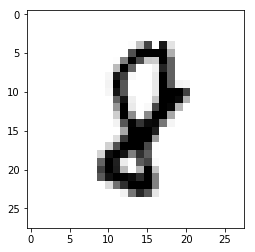

In [3]:
# Pull out a random image & its label
random_image_index = 200
random_image = mnist.train.images[random_image_index]
random_image_label = mnist.train.labels[random_image_index]

# Print the label and the image as grayscale
print("Image label: %d"%(random_image_label.argmax()))
pil_image = Image.fromarray(((random_image.reshape(28,28)) * 256).astype('uint8'), "L")
imshow(ImageOps.invert(pil_image), cmap='gray')

---
## Logistic Regression - Softmax
---

Now let's build a softmax classifier (linear) to classify MNIST images. We will use Mini-batch gradient descent for optimization

First, declare some of the hyperparameters that will be used by our softmax

In [4]:
# Softmax hyperparameters
learning_rate = 0.5
training_epochs = 5
batch_size = 100

* **Step 1**: Create placeholders to hold the images. 

  Using `None` for a dimension in shape means it can be *any* number.

In [5]:
# Create placeholders
x = tf.placeholder(tf.float32, shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))

* **Step 2**: Create variables to hold the weight matrix and the bias vector 

In [6]:
# Model parameters that have to be learned
# Initialize with zeros
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

* **Step 3**: Lets compute the label distribution. Apply the linear function W * X + b for each of the 10 classes. Then apply the softmax function to get a probability distribution of likelihoods for classes.  
  Recall that softmax(x) = exp(x)/ sum_i(exp(i)) where i represents each class
  
  
* **Step 4**: Compute the loss function as the cross entropy between the predicted distribution of the labels and its true distribution.  
  Cross entropy H(Y) = - sum_i( true_dist(i) * log (computed_dist(i)) 

In [7]:
# Get all the logits i.e. W * X + b for each of the class
logits = tf.matmul(x, W) + b
# Take a softmax of the logits. 
y_predicted = tf.nn.softmax(logits)

# Make sure you reduce the sum across columns.
# The y_predicted has a shape of number_of_examples * 10
# Cross entropy should first sum across columns to get individual cost and then average this error over all examples
cross_entropy_loss = tf.reduce_mean(- tf.reduce_sum(y * tf.log(y_predicted ), axis=1))

# This can apparently be numerically unstable. 
# Tensorflow provides a function that computes the logits, applies softmax and computes the cross entropy
# The example above is split only for pedagogical purposes
# logits = tf.matmul(x, W) + b
# cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)) 

* **Step 5**: Lets create a gradient descent optimizer to minimize the cross entropy loss

In [8]:
# Create an optimizer with the learning rate
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
# Use the optimizer to minimize the loss
train_step = optimizer.minimize(cross_entropy_loss)

* **Step 6**: Lets compute the accuracy 

In [9]:
# First create the correct prediction by taking the maximum value from the prediction class
# and checking it with the actual class. The result is a boolean column vector
correct_predictions = tf.equal(tf.argmax(y_predicted, 1), tf.argmax(y, 1))
# Calculate the accuracy over all the images
# Cast the boolean vector into float (1s & 0s) and then compute the average. 
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

Now lets run our graph as usual

In [10]:
# Initializing global variables
init = tf.global_variables_initializer()

# Create a session to run the graph
with tf.Session() as sess:
    # Run initialization
    sess.run(init)

    # For the set number of epochs
    for epoch in range(training_epochs):
        
        # Compute the total number of batches
        num_batches = int(mnist.train.num_examples/batch_size)
        
        # Iterate over all the examples (1 epoch)
        for batch_num in range(num_batches):
            
            # Get a batch of examples
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # Now run the session 
            curr_loss, cur_accuracy, _ = sess.run([cross_entropy_loss, accuracy, train_step], 
                                                    feed_dict={x: batch_xs, y: batch_ys})
            
            if batch_num % 50 == 0:
                display.clear_output(wait=True)
                time.sleep(0.1)
                # Print the loss
                print("Epoch: %d/%d. Batch #: %d/%d. Current loss: %.5f. Train Accuracy: %.2f"
                      %(epoch, training_epochs, batch_num, num_batches, curr_loss, cur_accuracy))

    # Run the session to compute the value and print it
    test_accuracy = sess.run(accuracy,
                                       feed_dict={x: mnist.test.images, 
                                                  y: mnist.test.labels})
    print("Test Accuracy: %.2f"%test_accuracy)

Epoch: 4/5. Batch #: 500/550. Current loss: 0.27087. Train Accuracy: 0.92
Test Accuracy: 0.92
